# 根据细胞的性状特征刻画不同细胞类型之间的关系，并进行评价和验证

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 12
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
# 设置全局字体
plt.rcParams['font.family']=' Times New Roman, SimSun'# 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [2]:
'''根据细胞类型的性状特征衡量细胞类型之间的相似性'''
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
core = "core"
for trait in range(1,50):
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    alltraits_significant[trait_name] = df["fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
alltraits_significant_T = alltraits_significant.T
cosine_similarities = pd.DataFrame(index=alltraits_significant_T.columns, columns=alltraits_significant_T.columns)
for col1 in alltraits_significant_T.columns:
    for col2 in alltraits_significant_T.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant_T[col1], alltraits_significant_T[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1

In [ ]:
## 1。 ['nk cell','fibroblast','mast cell','endothelial cell','neutrophil','plasma cell',' b cell',' t cell']每个细胞类型内部和与其他细胞类型相似性的分布

([<matplotlib.axis.XTick at 0x1c08d571280>,
 [Text(1, 0, 'Intra'), Text(2, 0, 'Inter')])

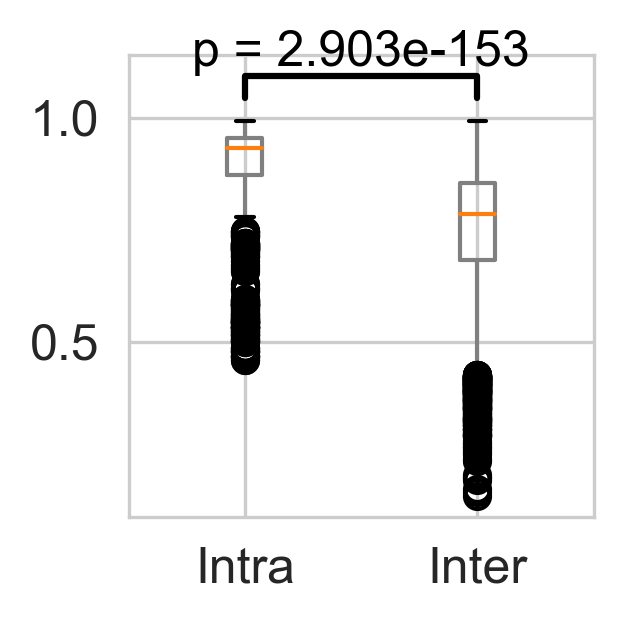

In [228]:
# 筛选包含 't cell' 子串的所有元素
ct_name = alltraits_significant.index
# filtered_name = [item for item in ct_name if 'plasma cell' in item.lower()]
# filtered_name = [item for item in ct_name if 'erythrocyte' in item.lower()]
# filtered_name = [item for item in ct_name if 'monocyte' in item.lower()]
# filtered_name = [item for item in ct_name if 'basal cell' in item.lower()]
# filtered_name = [item for item in ct_name if 'dendritic' in item.lower()]
# filtered_name = [item for item in ct_name if 'muscle' in item.lower()]
filtered_name = [item for item in ct_name if 'b cell' in item.lower()]
# filtered_name = [item for item in ct_name if 'club cell' not in item.lower()]
filtered_df = cosine_similarities.loc[filtered_name]
# ## b细胞和b细胞的相似性
tt = filtered_df[filtered_name]
mask = ~np.eye(tt.shape[0], dtype=bool)  # 使用布尔索引掩盖对角线元素
ttlist = tt.where(mask).stack().tolist()  # 提取非对角线元素
# ## b细胞和其他细胞类型的相似性
tNot = filtered_df[filtered_df.columns.difference(filtered_name)]
tNotlist = tNot.stack().tolist()

from scipy.stats import mannwhitneyu
corr_list = [ttlist, tNotlist]
# 箱线图
plt.figure(figsize=(2, 2),dpi = 300)
box = plt.boxplot(corr_list, boxprops=dict(color='grey'), whiskerprops=dict(color='grey'))

from scipy.stats import ttest_ind
# 计算 p 值
# stat, p_value = mannwhitneyu(ttlist, tNotlist, alternative='two-sided')
t_stat, p_value = ttest_ind(ttlist, tNotlist)
# 在箱体之间添加标示线和 p 值
x1, x2 = 1, 2
y, h, col = max(max(ttlist), max(tNotlist)) + 0.05, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5, y + h, f"p = {p_value:.3e}", ha='center', va='bottom', color=col, fontsize=12)

# 设置自定义横轴坐标值和标签
custom_ticks = [1, 2]  # 自定义的横轴坐标值
custom_labels = ["Intra", "Inter"]  # 对应的标签
plt.xticks(custom_ticks, custom_labels)

In [36]:
## 每种细胞类型中包含的细胞类型数量
ct_name = alltraits_significant.index
num_list = []
celltypes = [' b cell',' t cell','nk cell','fibroblast','mast cell','endothelial cell','neutrophil','plasma cell',"monocyte","basal cell","dendritic","muscle"]
celltypes_name = ['B细胞','T细胞','NK细胞','纤维细胞','肥大细胞','内皮细胞','中性粒细胞','浆细胞',"单核细胞","基质细胞","树突细胞","肌肉细胞"]
for filter_type in celltypes:
    filtered_name = [item for item in ct_name if filter_type in item.lower()]
    filtered_df = cosine_similarities.loc[filtered_name]
    num_list.append(len(filtered_df))
df = pd.DataFrame([celltypes, num_list]).T

df.columns = ["Celltype","Num"]
df_sorted = df.sort_values(by="Num",ascending=False)
df_sorted["Celltype name"]=['T细胞','内皮细胞','肌肉细胞','成纤维细胞','单核细胞','浆细胞','树突细胞','NK细胞',"中性粒细胞","B细胞","肥大细胞","基质细胞"]

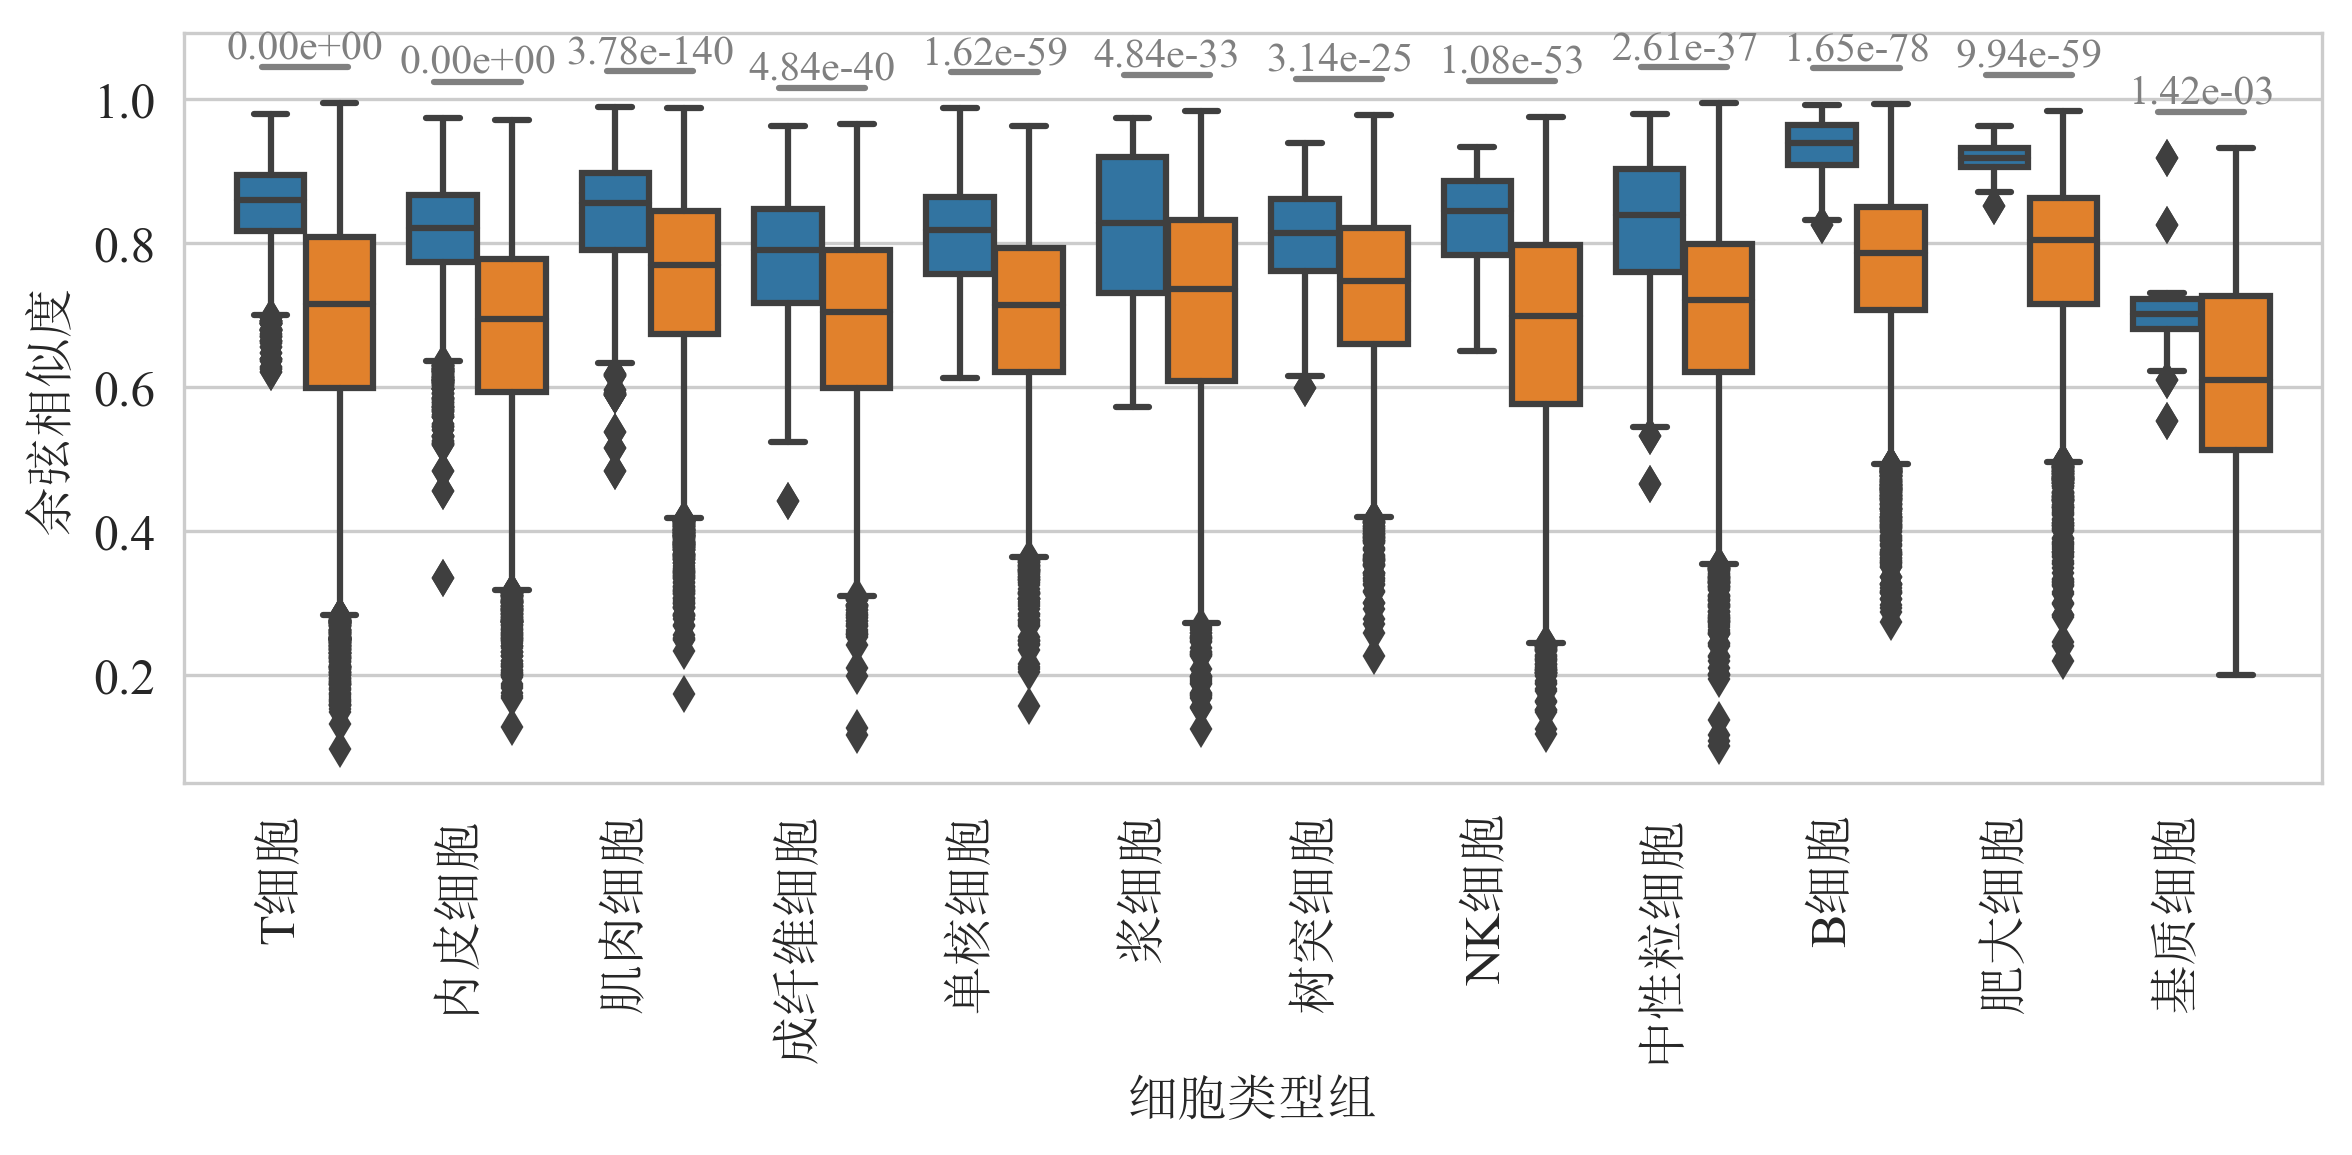

In [37]:
from scipy.stats import ttest_ind

plt.rcParams['font.family']=' Times New Roman, SimSun'# 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
# 设置全局字体大小
plt.rcParams['font.size'] = 12  # 设置全局字体大小

ct_name = alltraits_significant.index
data = []
p_values = []
# celltypes = ['b cell',' t cell','nk cell','fibroblast','mast cell','endothelial cell','neutrophil','plasma cell',"monocyte","basal cell","dendritic","muscle"]
for filter_type in list(df_sorted["Celltype"]):
    filtered_name = [item for item in ct_name if filter_type in item.lower()]
    filtered_df = cosine_similarities.loc[filtered_name]
    # ## b细胞和b细胞的相似性
    tt = filtered_df[filtered_name]
    mask = ~np.eye(tt.shape[0], dtype=bool)  # 使用布尔索引掩盖对角线元素
    ttlist = tt.where(mask).stack().tolist()  # 提取非对角线元素
    # ## b细胞和其他细胞类型的相似性
    tNot = filtered_df[filtered_df.columns.difference(filtered_name)]
    tNotlist = tNot.stack().tolist()
    filtered_list = [ttlist,tNotlist]
    data.append(filtered_list)
    
data = pd.DataFrame(data).T
# data.columns = celltypes
data.columns = df_sorted["Celltype name"]

data.index = ["Intra","Inter"]
# 将数据转换为 DataFrame
box_data = []
for group, values in data.items():
    for i, val in enumerate(values):
        label = 'Intra' if i == 0 else 'Inter'
        box_data.extend([(group, label, v) for v in val])
       
    # 计算每组两个列表之间的 p-value
    p_value = ttest_ind(values[0], values[1]).pvalue
    p_values.append((group, p_value))
    
df = pd.DataFrame(box_data, columns=['Group', 'List', 'Value'])

# 创建一个图形对象和子图对象
fig, ax = plt.subplots(figsize=(8, 4),dpi = 300)

# 使用 seaborn 绘制箱线图
sns.boxplot(x='Group', y='Value', hue='List', data=df, ax=ax)
# 添加 p-value 到箱线图
# 添加标示线和 p 值到箱线图
for i, (group, p_value) in enumerate(p_values):
    # 获取当前组的两个箱线图的最大值位置
    max_y1 = df[(df['Group'] == group) & (df['List'] == 'Intra')]['Value'].max()
    max_y2 = df[(df['Group'] == group) & (df['List'] == 'Inter')]['Value'].max()
    max_y = max(max_y1, max_y2)

    # 在两个箱线图的上方添加标示线
    ax.plot([i - 0.25, i + 0.25], [max_y + 0.05, max_y + 0.05], color='grey')
    
    # 在标示线上方添加 p 值
    # ax.text(i, max_y + 0.05, f'p = {p_value:.2e}', ha='center', va='bottom', fontsize=10, color='grey')
    ax.text(i, max_y + 0.05, f'{p_value:.2e}', ha='center', va='bottom', fontsize=10, color='grey')

# 设置图表标题和标签
# ax.set_title('Box Plots for Each Group with Two Lists')
ax.set_xlabel('细胞类型组')
ax.set_ylabel('余弦相似度')
# 旋转 x 轴标签
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
# 设置图例标签
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Intra', 'Inter'], loc='upper right')
# 隐藏图例
ax.get_legend().remove()
# 显示图表
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\figures\7.jpg",)
plt.show()

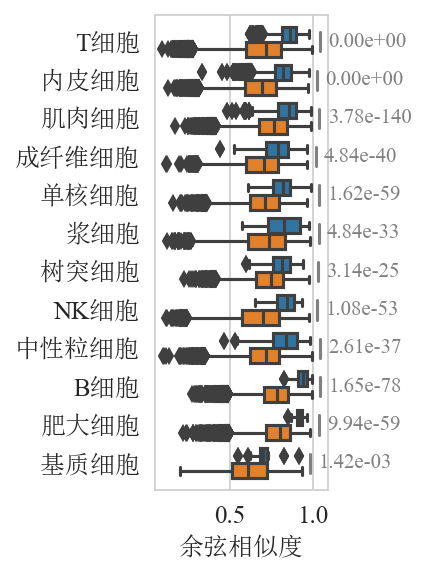

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# 假设 data 和 df_sorted 已经定义
data = pd.DataFrame(data).T
data.columns = df_sorted["Celltype name"]
data.index = ["Intra", "Inter"]

# 将数据转换为 DataFrame
box_data = []
p_values = []
for group, values in data.items():
    for i, val in enumerate(values):
        label = 'Intra' if i == 0 else 'Inter'
        box_data.extend([(group, label, v) for v in val])

    # 计算每组两个列表之间的 p-value
    p_value = ttest_ind(values[0], values[1]).pvalue
    p_values.append((group, p_value))

df = pd.DataFrame(box_data, columns=['Group', 'List', 'Value'])

# 创建一个图形对象和子图对象
fig, ax = plt.subplots(figsize=(3, 4), dpi=150)  # 调整图形大小以适应纵向图

# 使用 seaborn 绘制箱线图（交换 x 和 y）
sns.boxplot(y='Group', x='Value', hue='List', data=df, ax=ax)

# 添加 p-value 到箱线图
for i, (group, p_value) in enumerate(p_values):
    # 获取当前组的两个箱线图的最大值位置
    max_x1 = df[(df['Group'] == group) & (df['List'] == 'Intra')]['Value'].max()
    max_x2 = df[(df['Group'] == group) & (df['List'] == 'Inter')]['Value'].max()
    max_x = max(max_x1, max_x2)

    # 在两个箱线图的右侧添加标示线
    ax.plot([max_x + 0.05, max_x + 0.05], [i - 0.25, i + 0.25], color='grey')

    # 在标示线右侧添加 p 值
    ax.text(max_x + 0.1, i, f'{p_value:.2e}', ha='left', va='center', fontsize=10, color='grey')

# 设置图表标题和标签
ax.set_ylabel('')  # 纵轴标签
ax.set_xlabel('余弦相似度')  # 横轴标签

# 旋转 x 轴标签（如果需要）
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')  # 纵轴标签不旋转

# 设置图例标签
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Intra', 'Inter'], loc='upper right')

#隐藏图例（如果需要）
ax.get_legend().remove()
# 显示图表
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\figures\7.jpg",)
plt.show()

In [21]:
## 每种细胞类型中包含的细胞类型数量
num_list = []
celltypes = ['b cell',' t cell','nk cell','fibroblast','mast cell','endothelial cell','neutrophil','plasma cell',"monocyte","basal cell","dendritic","muscle"]
for filter_type in celltypes:
    filtered_name = [item for item in ct_name if filter_type in item.lower()]
    filtered_df = cosine_similarities.loc[filtered_name]
    num_list.append(len(filtered_df))
df = pd.DataFrame([celltypes, num_list]).T

df.columns = ["Celltype","Num"]
df_sorted = df.sort_values(by="Num",ascending=False)
df_sorted["Celltype name"]=['T细胞','内皮细胞','肌肉细胞','成纤维细胞','单核细胞','浆细胞','树突细胞','NK细胞',"中性粒细胞","B细胞","肥大细胞","基质细胞"]

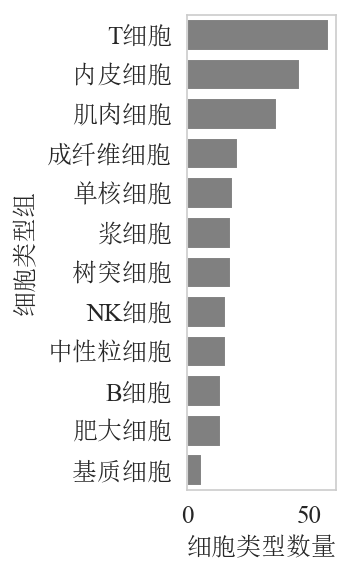

In [39]:
# 使用 Pandas 绘制柱状图
plt.figure(figsize=(2.5,4),dpi = 150)
ax = sns.barplot(x='Num', y='Celltype name', data=df_sorted,color = "grey")
plt.ylabel("细胞类型组")
plt.xlabel("细胞类型数量")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# 显示图表
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\figures\8.jpg",)
plt.grid(False)

## 研究的细胞类型包含的细胞数量

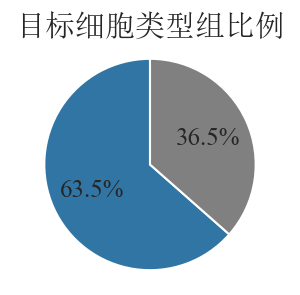

In [27]:
'''包含的细胞类型比例'''
ct_name = alltraits_significant.index
data = pd.DataFrame()
celltypes = ['b cell',' t cell','nk cell','fibroblast','mast cell','endothelial cell','neutrophil','plasma cell',"monocyte","basal cell","dendritic","muscle"]
celltypes_name = ['B细胞','T细胞','NK细胞','纤维细胞','肥大细胞','内皮细胞','中性粒细胞','浆细胞',"单核细胞","基质细胞","树突细胞","肌肉细胞"]
for filter_type in celltypes:
    filtered_name = [item for item in ct_name if filter_type in item.lower()]
    filtered_df = cosine_similarities.loc[filtered_name]
    # data.append(filtered_df)
    data = pd.concat([data, filtered_df], axis=0)
    
# 计算每个列表的元素数量
sizes = [len(data.index), len(data.columns) - len(data.index)]
labels = ['目标细胞类型组', ' ']
colors = ['#3175A4','grey']
fig, ax = plt.subplots(figsize=(2, 2),dpi = 150)
ax.pie(sizes, 
       # labels=[ ], 
       colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title("目标细胞类型组比例")
# 保证饼状图是圆形的
ax.axis('equal')
plt.savefig(r"E:\00_CeSOP\results\figures\9.jpg",)
plt.show()

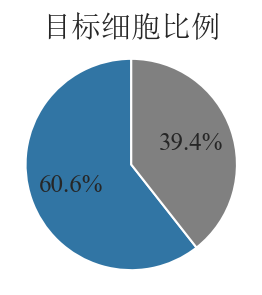

In [29]:
'''包含的细胞数量比例'''
data = pd.DataFrame()
celltypes = ['b cell',' t cell','nk cell','fibroblast','mast cell','endothelial cell','neutrophil','plasma cell',"monocyte","basal cell","dendritic","muscle"]
num_file = pd.read_excel(r"E:\00_CeSOP\data\24_tissues-celltype-cellnum.xlsx",sheet_name="tissue-celltype-cellnum")
for filter_type in celltypes:
    filtered_name = [item for item in num_file["celltype"] if filter_type in item.lower()]
    filtered_df = num_file[num_file["celltype"].isin(filtered_name)]
    data = pd.concat([data, filtered_df], axis=0)

# 计算每个列表的元素数量
sizes = [sum(data["cellnum"]), sum(num_file["cellnum"]) - sum(data["cellnum"])]
labels = ['Interest', 'No Interest']
colors = ['#3175A4','grey']
fig, ax = plt.subplots(figsize=(2, 2),dpi = 150)
ax.pie(sizes, 
       # labels=labels,
       colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title("目标细胞比例")
# 保证饼状图是圆形的
ax.axis('equal')
plt.savefig(r"E:\00_CeSOP\results\figures\10.jpg",)
plt.show()

## 根据细胞类型特异性对细胞类型进行聚类，并输出聚类结果'''

In [203]:
core= "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    alltraits_significant[trait_name] = df["fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]

alltraits_significant_T = alltraits_significant.T
'''计算每两列(细胞类型）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant_T.columns, columns=alltraits_significant_T.columns)
for col1 in alltraits_significant_T.columns:
    for col2 in alltraits_significant_T.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant_T[col1], alltraits_significant_T[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\celltypes_cosine_similarity_for_celltypes\edges.csv", index=None)

'''提取聚类结果'''
cosine_distance = pdist(alltraits_significant, metric='cosine')  # 计算余弦距离矩阵
linkage_matrix = sch.linkage(cosine_distance, method='complete')  # 生成层次聚类
array = alltraits_significant.iloc[:, 0:-1].to_numpy()
cluster_assignments = sch.fcluster(linkage_matrix, t=20, criterion='maxclust')  # 划分簇，设置簇数为3
# 添加簇分配结果到 DataFrame
alltraits_significant['Cluster'] = cluster_assignments
alltraits_significant['Cluster'].to_csv(r"E:\00_CeSOP\results\temp\cytoscape\celltypes_cosine_similarity_for_celltypes\nodes.csv")